In [1]:
import os, sys
from glob import glob
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.interpolate import interp1d, RegularGridInterpolator
from tqdm import *

import pickle

from scipy.integrate import quad

from grf.grf import TransitionProbabilities, PerturbedProbability, FIRAS
from grf.units import *
from grf.pk_interp import PowerSpectrumGridInterpolator

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Load plot style

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


# Get power spectra and analytic PDF

In [3]:
# Non-linear matter power spectrum. 
pspec_nonlin_matter       = PowerSpectrumGridInterpolator("nonlin_matter")
# Non-linear baryon power spectrum from simulations, lower limit. 
pspec_nonlin_baryon_lower = PowerSpectrumGridInterpolator("franken_lower")


# Analytic PDF. 
log_analytic_pdf_interp = pickle.load(open('../data/analytic_pdf_grids/log_analytic_pdf_interp.npy', 'rb'))

# Generate results class

In [4]:
# Class containing results with non-linear matter power spectrum. 
firas_nonlin            = FIRAS(pspec_nonlin_matter)
# Class containing results with non-linear baryon power spectrum from simulations, lower limit.
firas_nonlin_baryon_low = FIRAS(pspec_nonlin_baryon_lower)

../grf/grf.py:633: FutureWarning: read_table is deprecated, use read_csv instead.
  names=['freq', 'I', 'residual', 'uncert', 'poles'])


# Extract $m_\gamma^2$ PDFs

In [5]:
pdf_strings = ['lognormal', 'LN_b_1_5', 'analytic', 'voids', 'gaussian']

pdf_type_dict = dict.fromkeys(pdf_strings)

pdf_type_dict['lognormal'] = 'lognormal'
pdf_type_dict['analytic']  = log_analytic_pdf_interp
pdf_type_dict['LN_b_1_5']  = 'lognormal'
pdf_type_dict['voids']     = 'voids'
pdf_type_dict['gaussian']  = 'gaussian'

pdf_dict = dict.fromkeys(pdf_strings)

one_plus_delta_dict = dict.fromkeys(pdf_strings)

b_dict = dict.fromkeys(pdf_strings, 1.)
b_dict['LN_b_1_5'] = 1.5

m_Ap_ary = np.logspace(-26, -8, 500)

z_ary = np.array([1e-4])
omega_ary = np.array([firas_nonlin_baryon_low.omega_FIRAS[0]])

m_A_sq_z_0 = firas_nonlin_baryon_low.m_A_sq(z_ary, omega_ary)[0]
print(np.sqrt(m_A_sq_z_0) / eV)
    
for key in pdf_strings:
    
    pdf_dict[key] = np.zeros_like(m_Ap_ary)
    
    for i,m_Ap in enumerate(tqdm_notebook(m_Ap_ary)):
        
        if key != 'LN_b_1_5':

            pdf_dict[key][i] = firas_nonlin_baryon_low._dP_dz(
                z_ary = z_ary, m_Ap = m_Ap, k_min = 1e-3, k_max = 1e4,
                omega = omega_ary,
                pdf = pdf_type_dict[key],  b = b_dict[key], return_pdf=True
            )[2][0][0]
            
        else:
            
            pdf_dict[key][i] = firas_nonlin_baryon_low._dP_dz(
                z_ary = z_ary, m_Ap = m_Ap, k_min = 1e-3, k_max = 1e4,
                omega = omega_ary,
                pdf = pdf_type_dict[key],  b = b_dict[key], return_pdf=True
            )[2][0][0]

1.758226929292952e-14


/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


../grf/grf.py:366: RuntimeWarning: divide by zero encountered in log
  sigma_LN_sq_ary / 2.) ** 2 / (2 * sigma_LN_sq_ary)) * (1. / (m_Ap ** 2 + (b - 1) * m_A_sq))
../grf/grf.py:369: RuntimeWarning: divide by zero encountered in log
  ** 2 / (2 * sigma_LN_sq_ary)) / np.abs(self.dz_dt(z_mesh)) * (m_Ap ** 2 / (m_Ap ** 2 + (b - 1) * m_A_sq))


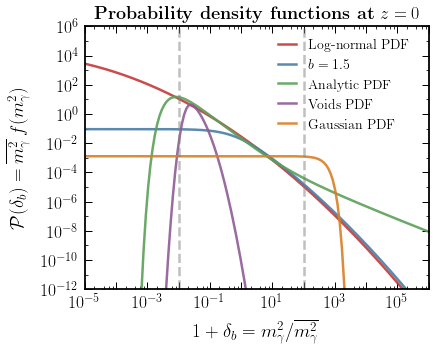

In [6]:
plt.figure(figsize=(8 / 1.3, 6.5 / 1.3))

plt.loglog()

labels = ['Log-normal PDF', r'$b = 1.5$', 'Analytic PDF', 'Voids PDF', 'Gaussian PDF']

ax = plt.gca()

for key,label in zip(pdf_dict,labels):

    plt.plot(m_Ap_ary**2 / m_A_sq_z_0, pdf_dict[key] * m_A_sq_z_0, label=label)

plt.axvline(x=1e-2, ls='--', c='gray', alpha=0.5)
plt.axvline(x=1e2,  ls='--', c='gray', alpha=0.5)
    
plt.legend(fontsize=14, loc='upper right', handlelength=1.3, bbox_to_anchor=(0.98, 1.))

plt.xlabel(r'$1 + \delta_b = m_\gamma^2 / \overline{m_\gamma^2}$')
plt.ylabel(r'$\mathcal{P}(\delta_b) = \overline{m_\gamma^2} \, f(m_\gamma^2)$')

plt.title(r'\textbf{Probability density functions at} $z = 0$')

    
plt.axis([1e-5, 1e6, 1e-12, 1e6])


from matplotlib import ticker

locmaj = ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)
ax.xaxis.set_major_formatter(
    ticker.FixedFormatter([
        '', r'$10^{-5}$', '', r'$10^{-3}$', '', r'$10^{-1}$', 
        '', r'$10^{1}$',  '', r'$10^{3}$' , '', r'$10^5$'
    ])
)

locmin = ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(ticker.NullFormatter())

locmaj = ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0, numticks=24)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

plt.tight_layout()

# plt.savefig('../paper/draft-letter/plots/PDFs.pdf')